In [1]:
import sys
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
import scipy as sp
from scipy import stats, integrate
import matplotlib.ticker as tk
import matplotlib as mpl
import os

sys.path.append('/home/jtb34/GitHub/GACF/')
from NGTS.NGTS_Field import return_field_from_object_directory, NGTSField
from NGTS.GACF_utils import TIME_CONVERSIONS, medsig#, #rebin_err
from NGTS import NGTSObject

from ngtsio import ngtsio

from tqdm import tqdm as tqdm

In [30]:
FIELDNAME = 'NG0442-3345' 
TEST = 'CYCLE1802'

In [31]:
n = 500
tdic = ngtsio.get(fieldname=FIELDNAME, ngts_version=TEST, keys=['OBJ_ID'])
nobjs = tdic['OBJ_ID'][:n]

('Field name:', 'NG0442-3345')
('NGTS version:', 'CYCLE1802')
('Object IDs (', 5059, '):', array(['000142', '000144', '000154', ..., '024179', '024180', '024191'],
      dtype='|S6'))
###############################################################################
Success: All keys successfully read into dictionary.
###############################################################################


In [32]:
# GET RMS by finding magnitude and RMS per NGTS LC

dic = ngtsio.get(fieldname=FIELDNAME, ngts_version=TEST, keys=['OBJ_ID', 'FLAGS', 'SYSREM_FLUX3', 'MAG_MEAN', 'BMAG', 'VMAG', 'RMAG', 'JMAG', 'HMAG', 'KMAG', 'HJD'], obj_id=nobjs)

('Field name:', 'NG0442-3345')
('NGTS version:', 'CYCLE1802')
('Object IDs (', 500, '):', array(['000142', '000144', '000154', '000232', '000490', '000498',
       '000533', '000549', '000568', '000573', '000598', '000599',
       '000601', '000602', '000605', '000606', '000607', '000608',
       '000609', '000610', '000612', '000615', '000622', '000640',
       '000729', '000734', '000744', '000745', '000746', '000776',
       '000792', '000794', '000795', '000796', '000797', '000800',
       '000803', '000813', '000822', '000826', '000834', '000837',
       '000840', '000849', '000859', '000860', '000865', '000869',
       '000878', '000884', '000891', '000894', '000899', '000910',
       '000913', '000928', '000930', '000934', '000940', '000944',
       '000945', '000957', '000965', '000967', '000968', '000969',
       '000970', '000972', '000973', '000978', '000979', '000980',
       '000984', '000992', '000995', '000996', '000998', '001005',
       '001006', '001008', '001010', '0

In [36]:
XMATCH_LOCATION = '/appch/data/jtb34/{}/cross_match/'.format(FIELDNAME)
FILE_NAME = 'Uncut_Final_{}.fits'.format(FIELDNAME)

from astropy.io import fits

In [37]:
xmatch_data = fits.open(os.path.join(XMATCH_LOCATION, FILE_NAME))[1]
gaia_mags = xmatch_data.data['Gaia_Gmag']

In [38]:
from tqdm import tqdm as tqdm




  0%|          | 0/500 [00:00<?, ?it/s]

  3%|▎         | 13/500 [00:31<19:43,  2.43s/it]
	 divide by zero encountered in divide


	 invalid value encountered in divide


	 invalid value encountered in less




  1%|          | 4/500 [00:01<02:19,  3.56it/s]


  1%|          | 5/500 [00:02<03:21,  2.45it/s]


  1%|          | 6/500 [00:02<03:12,  2.57it/s]


  1%|▏         | 7/500 [00:02<03:05,  2.65it/s]


  3%|▎         | 14/500 [00:02<01:43,  4.69it/s]


  3%|▎         | 15/500 [00:03<01:45,  4.58it/s]


  3%|▎         | 16/500 [00:03<01:48,  4.48it/s]


  3%|▎         | 17/500 [00:03<01:50,  4.37it/s]


  4%|▎         | 18/500 [00:04<01:52,  4.28it/s]


  4%|▍         | 19/500 [00:04<01:54,  4.21it/s]


  4%|▍         | 20/500 [00:04<01:55,  4.16it/s]


  4%|▍         | 22/500 [00:05<01:51,  4.28it/s]


  5%|▍         | 23/500 [00:05<01:53,  4.22it/s]


  5%|▍         | 24/500 [00:05<01:54,  4.16it/s]


  5%|▌         | 25/500 [00:06<01:55,  4.11it/s]


  5%|▌         | 26/500 [

Obj 000746, Mag 16.0185, rms 1.81577383814


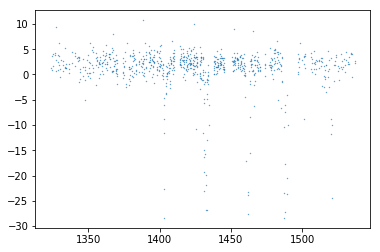

In [ ]:
data = {}
total = len(dic['OBJ_ID'])
for i, obj in enumerate(tqdm(dic['OBJ_ID'])):
#     print "Step {} of {}".format(i+1, total)
    flux = dic['SYSREM_FLUX3'][i]
    timeseries = dic['HJD'][i] / TIME_CONVERSIONS['d2s']

    idx_ok = np.where(dic['FLAGS'][i] == 0)
    flux = flux[idx_ok]
    timeseries = timeseries[idx_ok]

    med, sig = medsig(flux)
    flux = flux / med

    idx_3_sig = np.where(abs(flux - 1.0) < 3. * sig)
    flux = flux[idx_3_sig] # 3 sigma clipping step
    timeseries = timeseries[idx_3_sig] # 3 sigma clipping step

    try:
        timeseries, flux, _ = rebin_err_chunks(timeseries, flux, dt=60.0 * TIME_CONVERSIONS['m2d'])
    except ValueError as e:
        print 'Cannot process object {}'.format(obj)
        print e.message
        continue

    med, sig = medsig(flux)
    #     mag = dic['MAG_MEAN'][i]
    mag = gaia_mags[i]
    
    if np.isfinite(sig) and sig > 1.0:
        print 'Obj {}, Mag {}, rms {}'.format(obj, mag, sig)
        plt.scatter(timeseries, flux, s=0.1)
        plt.show()

        raw_input("Press Enter to continue...")

    data[obj] = {'rms': sig, 'mag': mag}

In [43]:
flux = dic['SYSREM_FLUX3'][i]
timeseries = dic['HJD'][i] / TIME_CONVERSIONS['d2s']

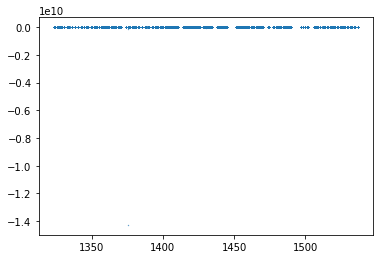

In [44]:
plt.scatter(timeseries, flux, s=0.1)
plt.show()

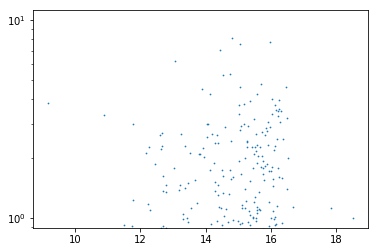

In [40]:
fig, ax = plt.subplots()
mags = [o['mag'] for o in data.values()]
rms = [o['rms'] for o in data.values()]
# rms = mags[::-1]

ax.scatter(mags, rms, s=0.5)
ax.set_yscale('log')
# ax.set_ylim([-2, 20])
# ax.set_xlim(15, -10)
plt.show()

In [ ]:
data

In [ ]:
# flux = dic['SYSREM_FLUX3'][3]
# med, sig = medsig(flux)
# print sig
# mean = np.nanmean(flux)
# idx_ok = np.where(dic['FLAGS'][3] == 0)
# flux = flux[idx_ok]
# flux = flux / med
# flux = flux[np.where((flux - 1.0) < 3 * sig)]
# plt.plot(flux, lw=0.1)
# # plt.ylim([-100,100])
# med, sig = medsig(flux)
# print sig

In [ ]:
data

In [ ]:
dic['RMAG']

In [7]:
def rebin_err(t, f, dt=0.02, get_err_on_mean=False, bin_about=None):
    """
    Rebin a time-series with errors on the data (y-points).
    Apply unweighted average: ignore errors on the data to be binned and
                              perform a simple MAD estimation of the error
                              from the scatter of points
    """
    treg = np.r_[t.min():t.max():dt]
    if bin_about is not None:
        treg = np.concatenate([np.r_[bin_about: t.min(): -dt][::-1],
                               np.r_[bin_about + dt: t.max():  dt]])
    nreg = len(treg)
    freg = np.zeros(nreg) + np.nan
    freg_err = np.zeros(nreg) + np.nan
    n_data = 0
    for i in np.arange(nreg):
        l = (t >= treg[i]) * (t < treg[i] + dt)
        if l.any():
            n_data += 1
            treg[i] = np.nanmean(t[l])
            freg[i], freg_err[i] = medsig(f[l])
            if get_err_on_mean:
                # freg_err[i] /= float(len(f[l]))
                freg_err[i] /= np.sqrt(float(len(f[l])))
    l = np.isfinite(freg)
    return treg[l], freg[l], freg_err[l]

In [ ]:
from time import time
def rebin_err_verbose(t, f, dt=0.02, get_err_on_mean=False, bin_about=None):
    """
    Rebin a time-series with errors on the data (y-points).
    Apply unweighted average: ignore errors on the data to be binned and
                              perform a simple MAD estimation of the error
                              from the scatter of points
    """
    start = time()
    treg = np.r_[t.min():t.max():dt]
    tregtime = time()
    if bin_about is not None:
        treg = np.concatenate([np.r_[bin_about: t.min(): -dt][::-1],
                               np.r_[bin_about + dt: t.max():  dt]])
    concattime = time()
    nreg = len(treg)
    freg = np.zeros(nreg) + np.nan
    freg_err = np.zeros(nreg) + np.nan
    loopstart = time()
    n_data = 0
    for i in np.arange(nreg):
        findstart = time()
        l = (t >= treg[i]) * (t < treg[i] + dt)
        findend = time()
        if l.any():
            n_data += 1
            nanmeanstart = time()
            treg[i] = np.nanmean(t[l])
            nanmeanend = time()
            freg[i], freg_err[i] = medsig(f[l])
            medsigend = time()
            if get_err_on_mean:
                # freg_err[i] /= float(len(f[l]))
                freg_err[i] /= np.sqrt(float(len(f[l])))
        inloopend = time()
    loopend = time()
    l = np.isfinite(freg)
    returntime = time()
    print 'tregtime', tregtime - start
    print 'concattime', concattime - tregtime
    print 'looptime', loopend - loopstart
    print '\t', 'findtime', findend - findstart
    print '\t', 'nanmeantime', nanmeanend - nanmeanstart
    print '\t', 'medsigtime', medsigend - nanmeanend
    print '\t', 'total', inloopend - findstart, '({})'.format((inloopend - findstart) * nreg), nreg
    print 'total', returntime - start
    print 'number of empty times: {} / {}'.format(nreg - n_data, nreg)
    return treg[l], freg[l], freg_err[l]

In [ ]:
i = 49
cleanstart = time()
# length = len(dic['SYSREM_FLUX3'][i]) / 8
flux = dic['SYSREM_FLUX3'][i]
timeseries = dic['HJD'][i] / TIME_CONVERSIONS['d2s']

idx_ok = np.where(dic['FLAGS'][i] == 0)
flux = flux[idx_ok]
timeseries = timeseries[idx_ok]

# med, sig = medsig(flux)
# flux = flux / med

# idx_3_sig = np.where(abs(flux - 1.0) < 3. * sig)
# flux = flux[idx_3_sig] # 3 sigma clipping step
# timeseries = timeseries[idx_3_sig] # 3 sigma clipping step
# cleanend = time()

# print 'cleaning time', cleanend-cleanstart

# _, flux, _ = rebin_err(timeseries, flux, dt=10.0 * TIME_CONVERSIONS['m2d'])

In [8]:
def segment_times(timeseries, max_gap):
    """
    Returns an N-D array where each row represents a separate segmentation of continuous data with no gaps
    greater than the max gap.
    """
    time_segments = []
    is_contiguous = False
    arr_n = -1
    for i, t in enumerate(timeseries):
        if not is_contiguous:
            time_segments.append([t])
            arr_n += 1
        else:
            time_segments[arr_n].append(t)
        if i+1 < len(timeseries):
            is_contiguous = (timeseries[i+1] - t) < max_gap
    return time_segments

In [9]:
def match_dimensions(ndarray, onedarray):
    ndreturn = []
    idx = 0 
    for sublist in ndarray:
        num = len(sublist)
        subreturn = onedarray[idx: idx+num]
        idx += num
        ndreturn.append(subreturn)
    return ndreturn

In [ ]:
times = segment_times(timeseries, 20.0 * TIME_CONVERSIONS['m2d'])
fluxes = match_dimensions(times, flux)

In [ ]:
plt.hist([len(t) for t in times], bins=50)
plt.show()
# [len(t) for t in times]

In [ ]:
plt.hist([a-b for a, b in zip(timeseries[1:], timeseries[:-1])], bins=100)
plt.ylim([0, 10])
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
for i in range(len(times)):
    ax.scatter(times[i], fluxes[i], s=0.1)
# ax.set_xlim([1.150e8, 1.160e8])
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(timeseries, flux, s=0.1)
plt.show()

In [ ]:
tbin1, fbin1, _ = rebin_err_verbose(timeseries, flux, dt=10.0 * TIME_CONVERSIONS['m2d'])

In [ ]:
from time import time
times_binned = []
fluxes_binned = []
flux_errs_binned = []
nreg = 0
n_data = 0
start = time()
for i, each_time in enumerate(times):
    tbin, fbin, ferr, n_data1, nreg1 = rebin_err(np.array(each_time), np.array(fluxes[i]), dt=10.0 * TIME_CONVERSIONS['m2d'])
    n_data += n_data1
    nreg += nreg1
    times_binned.append(tbin)
    fluxes_binned.append(fbin)
    flux_errs_binned.append(ferr)
end = time()
print 'Time taken {}, with {} / {} empty'.format(end-start, nreg-n_data, n_data)

In [ ]:
import itertools
tbin2 = list(itertools.chain(*times_binned))
fbin2 = list(itertools.chain(*fluxes_binned))

In [12]:
import itertools
def rebin_err_chunks(t, f, dt=0.02, get_err_on_mean=False):
    times = segment_times(t, dt)
    fluxes = match_dimensions(times, f)
    times_binned = []
    fluxes_binned = []
    flux_errs_binned = []
    nreg = 0
    n_data = 0
    for i, each_time in enumerate(times):
        tbin, fbin, ferr = rebin_err(np.array(each_time), np.array(fluxes[i]), 
                                     dt=dt, get_err_on_mean=get_err_on_mean)
        times_binned.append(tbin)
        fluxes_binned.append(fbin)
        flux_errs_binned.append(ferr)
    treg = list(itertools.chain(*times_binned))
    freg = list(itertools.chain(*fluxes_binned))
    freg_err = list(itertools.chain(*flux_errs_binned))
    
    return treg, freg, freg_err
        

In [ ]:
from time import time
start = time()
tbin3, fbin3, fregerr3 = rebin_err_chunks(timeseries, flux, dt=10.0*TIME_CONVERSIONS['m2d'])
end = time()
# tbin4, fbin4, fregerr4 = rebin_err(timeseries, flux, dt=1.0*TIME_CONVERSIONS['m2d'])
end2 = time()
print end-start, end2-end, end2-end / end-start

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
# ax.scatter(timeseries, flux, s=0.01)
ax.scatter(tbin3, fbin3, s=0.1)
# ax.scatter(tbin1, fbin1, s=0.1)
plt.show()

In [ ]:
len(tbin2)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
for i in range(len(times_binned)):
    ax.scatter(times_binned[i], fluxes_binned[i], s=0.1)
ax.set_xlim([1.150e8, 1.160e8])
plt.show()

In [ ]:
test_times = np.array([0, 1, 2, 10, 11, 12, 15, 40, 43, 45]) + 1e8
test_time_gap = 5
test_flux = np.random.rand(len(test_times)) * 0.01 +  1.0

In [ ]:
test_segments = segment_times(test_times, test_time_gap)
test_flux_segments = match_dimensions(test_segments, test_flux)

In [ ]:
test_segments

In [ ]:
for i in range(len(test_segments)):
    plt.scatter(test_segments[i], test_flux_segments[i])
plt.show()

In [ ]:
test_flux_segments